# Lane Detection Project

### import necessary Libraries

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math
%matplotlib inline

global first_frame

In [2]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

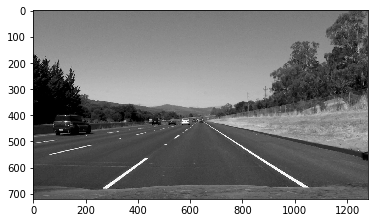

In [3]:
#Grayscale image with all pixels that are not yellow or white set to black/zero
image = cv2.imread('image.jpg')
gray_image = grayscale(image)
plt.imshow(gray_image, cmap='gray')
plt.show()

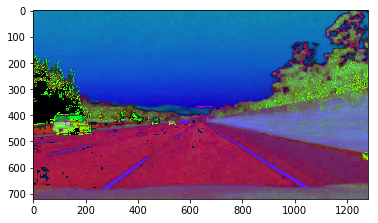

In [4]:
# hue saturation value
img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
plt.imshow(img_hsv, cmap='gray')
plt.show()

In [5]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel.
    Gaussian blur: This filter will help to suppress noise in 
    our Canny Edge Detection by averaging out the pixel values in a neighborhood.
    """
    
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [6]:
lower_yellow = np.array([20, 100, 100], dtype = "uint8")
upper_yellow = np.array([30, 255, 255], dtype = "uint8")

mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
mask_white = cv2.inRange(gray_image, 200, 255)
mask_yw = cv2.bitwise_or(mask_white, mask_yellow)
mask_yw_image = cv2.bitwise_and(gray_image, mask_yw)

kernel_size = 5

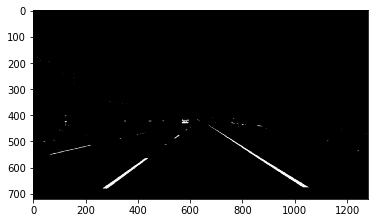

In [7]:
# GaussianBlur
gauss_gray = gaussian_blur(mask_yw_image,kernel_size)
plt.imshow(gauss_gray, cmap='gray')
plt.show()

In [8]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform
    Canny Edge Detection
    """
    return cv2.Canny(img, low_threshold, high_threshold)

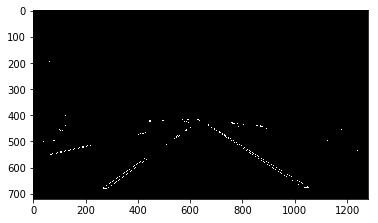

In [9]:
#same as quiz values
#John Canny himself recommended a low to high threshold ratio of 1:2 or 1:3.
low_threshold = 50
high_threshold = 150
canny_edges = canny(gauss_gray,low_threshold,high_threshold)
plt.imshow(canny_edges, cmap='gray')
plt.show()

In [10]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from vertices. The rest of the image is set to black/zero.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

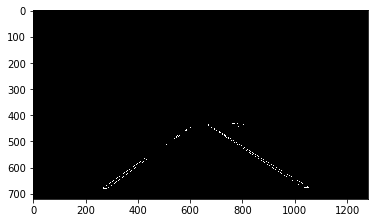

In [11]:
imshape = image.shape
lower_left = [imshape[1]/9, imshape[0]]
lower_right = [imshape[1]-imshape[1]/9, imshape[0]]
top_left = [imshape[1]/2-imshape[1]/8, imshape[0]/2+imshape[0]/10]
top_right = [imshape[1]/2+imshape[1]/8, imshape[0]/2+imshape[0]/10]
vertices = [np.array([lower_left, top_left, top_right, lower_right],dtype=np.int32)]
#print(vertices)
roi_image = region_of_interest(canny_edges, vertices)
# Plot Region of Interest
plt.imshow(roi_image, cmap='gray')
plt.show()


In [12]:
#used below
global first_frame
def get_slope(x1,y1,x2,y2):
    return (y2-y1)/(x2-x1)

In [13]:
#thick red lines 
def draw_lines(img, lines, color=[255, 0, 0], thickness=6):
    """workflow:
    1) examine each individual line returned by hough & determine if it's in left or right lane by its slope
    because we are working "upside down" with the array, the left lane will have a negative slope and right positive
    2) track extrema
    3) compute averages
    4) solve for b intercept 
    5) use extrema to solve for points
    6) smooth frames and cache
    """
    global cache
    global first_frame
    y_global_min = img.shape[0] #min will be the "highest" y value, or point down the road away from car
    y_max = img.shape[0]
    l_slope, r_slope = [],[]
    l_lane,r_lane = [],[]
    det_slope = 0.4
    alpha =0.2 
    #i got this alpha value off of the forums for the weighting between frames.
    #i understand what it does, but i dont understand where it comes from
    #much like some of the parameters in the hough function
    
    for line in lines:
        #1
        for x1,y1,x2,y2 in line:
            slope = get_slope(x1,y1,x2,y2)
            if slope > det_slope:
                r_slope.append(slope)
                r_lane.append(line)
            elif slope < -det_slope:
                l_slope.append(slope)
                l_lane.append(line)
        #2
        y_global_min = min(y1,y2,y_global_min)
    
    # to prevent errors in challenge video from dividing by zero
    if((len(l_lane) == 0) or (len(r_lane) == 0)):
        print ('no lane detected')
        return 1
        
    #3
    l_slope_mean = np.mean(l_slope,axis =0)
    r_slope_mean = np.mean(r_slope,axis =0)
    l_mean = np.mean(np.array(l_lane),axis=0)
    r_mean = np.mean(np.array(r_lane),axis=0)
    
    if ((r_slope_mean == 0) or (l_slope_mean == 0 )):
        print('dividing by zero')
        return 1
    
   
    
    #4, y=mx+b -> b = y -mx
    l_b = l_mean[0][1] - (l_slope_mean * l_mean[0][0])
    r_b = r_mean[0][1] - (r_slope_mean * r_mean[0][0])
    
    #5, using y-extrema (#2), b intercept (#4), and slope (#3) solve for x using y=mx+b
    # x = (y-b)/m
    # these 4 points are our two lines that we will pass to the draw function
    l_x1 = int((y_global_min - l_b)/l_slope_mean) 
    l_x2 = int((y_max - l_b)/l_slope_mean)   
    r_x1 = int((y_global_min - r_b)/r_slope_mean)
    r_x2 = int((y_max - r_b)/r_slope_mean)
    
    #6
    if l_x1 > r_x1:
        l_x1 = int((l_x1+r_x1)/2)
        r_x1 = l_x1
        l_y1 = int((l_slope_mean * l_x1 ) + l_intercept)
        r_y1 = int((r_slope_mean * r_x1 ) + r_intercept)
        l_y2 = int((l_slope_mean * l_x2 ) + l_intercept)
        r_y2 = int((r_slope_mean * r_x2 ) + r_intercept)
    else:
        l_y1 = y_global_min
        l_y2 = y_max
        r_y1 = y_global_min
        r_y2 = y_max
      
    current_frame = np.array([l_x1,l_y1,l_x2,l_y2,r_x1,r_y1,r_x2,r_y2],dtype ="float32")
    
    if first_frame == 1:
        next_frame = current_frame        
        first_frame = 0        
    else :
        prev_frame = cache
        next_frame = (1-alpha)*prev_frame + alpha*current_frame
             
    cv2.line(img, (int(next_frame[0]), int(next_frame[1])), (int(next_frame[2]),int(next_frame[3])), color, thickness)
    cv2.line(img, (int(next_frame[4]), int(next_frame[5])), (int(next_frame[6]),int(next_frame[7])), color, thickness)
    
    cache = next_frame
    

In [14]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #print(lines)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img,lines)
    return line_img

In [15]:
import numpy as np
#rho and theta are the distance and angular resolution of the grid in Hough space
rho = 4
theta = np.pi/180

#threshold is minimum number of intersections in a grid for candidate line to go to output
threshold = 30
min_line_len = 100
max_line_gap = 180
#my hough values started closer to the values in the quiz, but got bumped up considerably for the challenge video
first_frame = 1
 

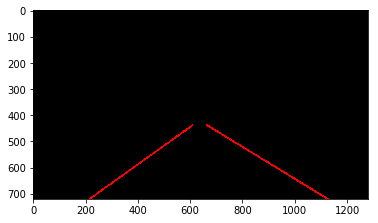

In [16]:
# Apply Hough Transform
#global first_frame
line_image = hough_lines(roi_image, rho, theta, threshold, min_line_len, max_line_gap)
plt.imshow(line_image, cmap='gray')
plt.show()

#### Oww!!! we draw Lines from Hough transform

In [17]:
def weighted_img(img, initial_img, alpha = 0.8, beta = 1., lmd = 0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * alpha + img * beta + lmd
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, lmd)

#### original, unaltered image of the road to have a nice, smooth overlay.

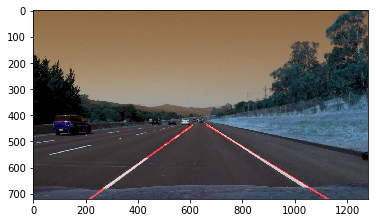

In [18]:
complete = weighted_img(line_image, image, alpha = 0.8, beta = 1., lmd = 0.)
plt.imshow(complete, cmap='gray')
plt.show()

In [19]:
### Now Apply this real Images
def process_image(image):
    
    global first_frame

    gray_image = grayscale(image)
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    #hsv = [hue, saturation, value]
    #more accurate range for yellow since it is not strictly black, white, r, g, or b

    lower_yellow = np.array([20, 100, 100], dtype = "uint8")
    upper_yellow = np.array([30, 255, 255], dtype="uint8")

    mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
    mask_white = cv2.inRange(gray_image, 200, 255)
    mask_yw = cv2.bitwise_or(mask_white, mask_yellow)
    mask_yw_image = cv2.bitwise_and(gray_image, mask_yw)

    kernel_size = 5
    gauss_gray = gaussian_blur(mask_yw_image,kernel_size)

    #same as quiz values
    low_threshold = 50
    high_threshold = 150
    canny_edges = canny(gauss_gray,low_threshold,high_threshold)

    imshape = image.shape
    lower_left = [imshape[1]/9,imshape[0]]
    lower_right = [imshape[1]-imshape[1]/9,imshape[0]]
    top_left = [imshape[1]/2-imshape[1]/8,imshape[0]/2+imshape[0]/10]
    top_right = [imshape[1]/2+imshape[1]/8,imshape[0]/2+imshape[0]/10]
    vertices = [np.array([lower_left,top_left,top_right,lower_right],dtype=np.int32)]
    roi_image = region_of_interest(canny_edges, vertices)

    #rho and theta are the distance and angular resolution of the grid in Hough space
    #same values as quiz
    rho = 4
    theta = np.pi/180
    #threshold is minimum number of intersections in a grid for candidate line to go to output
    threshold = 30
    min_line_len = 100
    max_line_gap = 180
    #my hough values started closer to the values in the quiz, but got bumped up considerably for the challenge video

    line_image = hough_lines(roi_image, rho, theta, threshold, min_line_len, max_line_gap)
    result = weighted_img(line_image, image, alpha = 0.8, beta = 1., lmd = 0.)
    return result


In [20]:
## For ploting the images
def plt_show(image, title=""):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis("off") 
    plt.title(title)
    plt.imshow(image, cmap="Greys_r")
    plt.show()

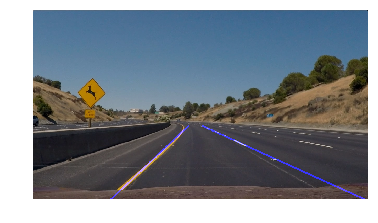

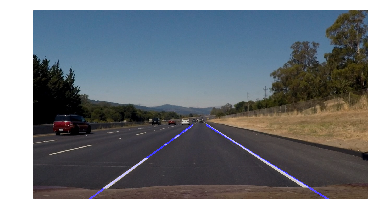

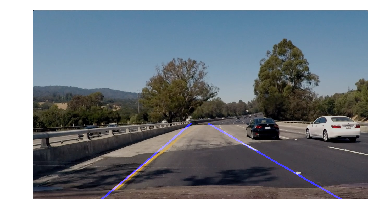

no lane detected


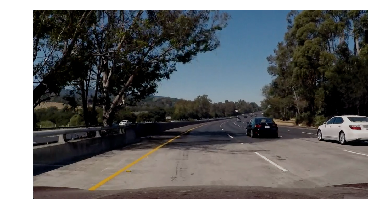

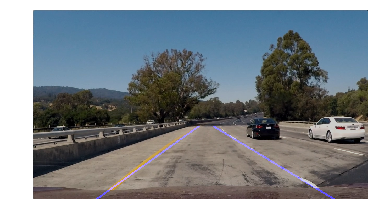

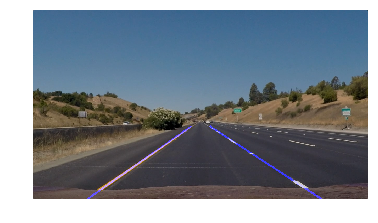

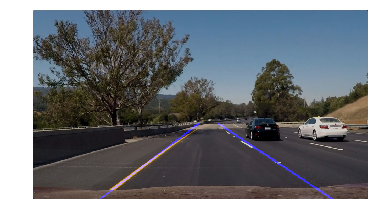

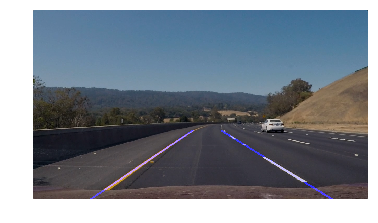

In [21]:
for source_img in os.listdir("test_images/"):
    first_frame = 1
    image = cv2.imread("test_images/"+source_img)
    processed = process_image(image)
    plt_show(processed)
    mpimg.imsave("out_images/annotated_"+source_img,processed)

In [22]:

first_frame = 1
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:08<00:00, 25.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 10.2 s, sys: 2.79 s, total: 13 s
Wall time: 9.92 s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [24]:
first_frame = 1
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:31<00:00, 21.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 32.3 s, sys: 8.73 s, total: 41 s
Wall time: 33.5 s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Chalange Videos

In [26]:
first_frame = 1
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)
#TODO how do we make curved ROI and curved lines? we need some calculus up in this bizzzz

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


 63%|██████▎   | 158/251 [00:11<00:08, 11.40it/s]

no lane detected
no lane detected
no lane detected


100%|██████████| 251/251 [00:20<00:00, 12.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 21.6 s, sys: 6.04 s, total: 27.6 s
Wall time: 22.8 s


In [27]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

# End of Lane Detection Project